# From MARC to LOD: Mining and Publishing Bibliographic Data with Python 
Description

## Step 1: Import needed libraries
Description

In [1]:
import os, re, pymarc
import internetarchive as ia
import pandas as pd
import missingno as msgno

## Step 2: Data selection
Description

In [2]:
# Define the name of the collection on Internet Archive
collection_name = "darwinslibrary"

In [3]:
# Define the path where the files will be saved
save_path = "marc-files"

# Create the directory if it doesn't exist
if not os.path.exists(save_path):
    os.mkdir(save_path)

In [4]:
# Search for items in the collection
items = ia.search_items(f'collection:{collection_name}')

## Step 3: Download the collection

In [5]:
# For each item, download the MARCXML record
for item in items:
    identifier = item["identifier"]
    
    try:
        xml_files = ia.download(identifier, 
                                formats=["MARC"], 
                                verbose=True, 
                                destdir=save_path,
                                no_directory=True)

    # If there is a error, print it
    except Exception as e:
        print(e)

Abercrombie1838wa66W:
 skipping marc-files\Abercrombie1838wa66W_marc.xml, file already exists based on length and date.
Abercrombie1838wa66W_MS:
 skipping marc-files\Abercrombie1838wa66W_MS_marc.xml, file already exists based on length and date.
Agassiz1850up52I:
 skipping marc-files\Agassiz1850up52I_marc.xml, file already exists based on length and date.
Agassiz1850up52I_MS:
 skipping marc-files\Agassiz1850up52I_MS_marc.xml, file already exists based on length and date.
Agassiz2006ft69Y:
 skipping marc-files\Agassiz2006ft69Y_marc.xml, file already exists based on length and date.
Agassiz2006ft69Y_MS:
 skipping marc-files\Agassiz2006ft69Y_MS_marc.xml, file already exists based on length and date.
Barker-Webb1840yf41S:
 skipping marc-files\Barker-Webb1840yf41S_marc.xml, file already exists based on length and date.
Barker-Webb1840yf41S_MS:
 skipping marc-files\Barker-Webb1840yf41S_MS_marc.xml, file already exists based on length and date.
Bechstein1840ob74D:
 skipping marc-files\Bechste

## Step 4: Get the data
Description

In [6]:
# Prepare the list of dictionaries
data = []

In [7]:
def get_author(record):
    '''
    Get the "author" metadata from a MARCXML record.

    Args:
        record (file): a MARCXML file containing the metadata of a record.

    Returns:
        author (str): a string containing the name of the author extracted from the MARCXML file.
    '''
    try:
        author = record['100']['a']
        return author
    except Exception as e:
        print(e)

In [8]:
def get_title(record):
    '''
    Get the "title" metadata from a MARCXML record.

    Args:
        record (file): a MARCXML file containing the metadata of a record.

    Returns:
        title (str): a string containing the title of the record extracted from the MARCXML file.
    '''
    try:
        title = record['245']['a']
        return title
    except Exception as e:
        print(e)

In [9]:
def get_pub_place(record):
    '''
    Get the "publication place" metadata from a MARCXML record.

    Args:
        record (file): a MARCXML file containing the metadata of a record.

    Returns:
        pub_place (str): a string containing the name of the publication place extracted from the MARCXML file.
    '''
    try:
        pub_place = record['260']['a']
        return pub_place
    except Exception as e:
        print(e)

In [10]:
def get_publisher(record):
    '''
    Get the "publisher" metadata from a MARCXML record.

    Args:
        record (file): a MARCXML file containing the metadata of a record.

    Returns:
        publisher (str): a string containing the name of the publisher extracted from the MARCXML file.
    '''
    try:
        publisher = record['260']['b']
        return publisher
    except Exception as e:
        print(e)

In [11]:
def get_pub_date(record):
    '''
    Get the "publication date" metadata from a MARCXML record.

    Args:
        record (file): a MARCXML file containing the metadata of a record.

    Returns:
        pub_date (str): a string containing the publication date extracted from the MARCXML file.
    '''
    try:
        pub_date = record['260']['c']
        return pub_date
    except Exception as e:
        print(e)

In [12]:
# Some fields like subjects can repeat. In cases like that you will want to 
# use get_fields to get all of them as pymarc.Field objects

def get_note(record):
    '''
    Get the "note" metadata from a MARCXML record.

    Args:
        record (file): a MARCXML file containing the metadata of a record.

    Returns:
        notes (list): a list of strings containing notes extracted from the MARCXML file.
    '''
    try:
        notes = [note['a'] for note in record.get_fields('500')]
        return notes
    except Exception as e:
        print(e)

In [13]:
def get_ident(lst):
    '''
    Get the "identifier" metadata from a MARCXML record.

    Args:
        record (file): a MARCXML file containing the metadata of a record.

    Returns:
        ident (str): a string containing the identifier extracted from the MARCXML file.
    '''
    try:
        for strng in lst:
            if strng.startswith('Identifier'):
                ident = strng[12:]
                return ident.lower()
    except Exception as e:
        print(e)

In [14]:
def get_alt_ident(lst):
    '''
    Get alternative identifier metadata from a MARCXML record.

    Args:
        record (file): a MARCXML file containing the metadata of a record.

    Returns:
        ident (str): a string containing an alternative identifier extracted from the MARCXML file.
    '''
    try:
        for strng in lst:
            if strng.startswith('Public number: '):
                ident = strng[15:]
                return ident
    except Exception as e:
        print(e)

In [15]:
def get_manuscript(record):
    '''
    Get the "supplement special issue entry" metadata from a MARCXML record.

    Args:
        record (file): a MARCXML file containing the metadata of a record.

    Returns:
        manuscript (str): a string containing the identifier of the supplement special issue entry extracted from the MARCXML file.
    '''
    try:
        manuscript = record['770']['o']
        return manuscript.lower()
    except Exception as e:
        print(e)

In [16]:
def get_parent(record):
    '''
    Get the "supplement parent entry" metadata from a MARCXML record.

    Args:
        record (file): a MARCXML file containing the metadata of a record.

    Returns:
        parent (str): a string containing the identifier of the supplement parent entry extracted from the MARCXML file.
    '''
    try:
        parent = record['772']['o']
        return parent.lower()
    except Exception as e:
        print(e)

In [ ]:
# Iterate over the folder
for filename in os.listdir(save_path):

    # Construct the path to the MARCXML file in the current folder
    file_path = os.path.join(save_path, filename)

    # Check if the file exists at that path
    if os.path.isfile(file_path):
        
        # Open the MARCXML file
        with open(file_path, 'rb') as marc_file:
            records = pymarc.marcxml.parse_xml_to_array(marc_file)
    
            # Iterate over the MARC records in the file
            # and generate a dictionary for each record
            for record in records:
                dct = {
                    'ID': get_ident(get_note(record)),
                    'ALT_ID': get_alt_ident(get_note(record)),
                    'AUTHOR': get_author(record),
                    'TITLE': get_title(record),
                    'NOTE': ' '.join(get_note(record)),
                    'MANUSCRIPT': get_manuscript(record),
                    'PARENT': get_parent(record),
                    'PUB_PLACE': get_pub_place(record),
                    'PUBLISHER': get_publisher(record),
                    'PUB_DATE': get_pub_date(record)
                }
                data.append(dct)

## Data conversion
Description

In [18]:
def normalize_missing_value(value):
    try:
        value = re.sub(r'\[s.n.\]|n.d.', 'None', value)
    except:
        None
    return value

In [19]:
def clean_value(value):
    try:
        value = re.sub(r'[.,!?:;\s]+$', '', value)
    except:
        None
    return value

In [20]:
clean_data = []

In [21]:
for dct in data:
    clean_dct = {key: normalize_missing_value(value) for key, value in dct.items()}
    clean_dct = {key: clean_value(value) for key, value in clean_dct.items()}
    clean_data.append(clean_dct)

In [22]:
print(clean_data)

[{'ID': 'abercrombie1838wa66w', 'ALT_ID': '0001', 'AUTHOR': 'Abercrombie, John', 'TITLE': 'Inquiries concerning the intellectual powers and the investigation of truth', 'NOTE': 'Location: Cambridge. Identifier: Abercrombie1838wa66W. Public number: 0001', 'MANUSCRIPT': 'abercrombie1838wa66w_ms', 'PARENT': None, 'PUB_PLACE': 'London', 'PUBLISHER': 'John Murray', 'PUB_DATE': '1838'}, {'ID': 'abercrombie1838wa66w_ms', 'ALT_ID': None, 'AUTHOR': 'Darwin, Charles', 'TITLE': 'Inquiries concerning the intellectual powers and the investigation of truth', 'NOTE': 'Identifier: Abercrombie1838wa66W_MS', 'MANUSCRIPT': None, 'PARENT': 'abercrombie1838wa66w', 'PUB_PLACE': None, 'PUBLISHER': None, 'PUB_DATE': None}, {'ID': 'agassiz1850up52i', 'ALT_ID': '0017', 'AUTHOR': 'Agassiz, Louis', 'TITLE': 'Lake Superior: its character, vegetation, and animals, compared with those of other similar regions', 'NOTE': 'Inscription. Location: Cambridge. Identifier: Agassiz1850up52I. Public number: 0017', 'MANUSCRIPT

In [23]:
df = pd.DataFrame(clean_data)

In [24]:
print(df.head())

                        ID ALT_ID             AUTHOR  \
0     abercrombie1838wa66w   0001  Abercrombie, John   
1  abercrombie1838wa66w_ms   None    Darwin, Charles   
2         agassiz1850up52i   0017     Agassiz, Louis   
3      agassiz1850up52i_ms   None    Darwin, Charles   
4         agassiz2006ft69y   0015     Agassiz, Louis   

                                               TITLE  \
0  Inquiries concerning the intellectual powers a...   
1  Inquiries concerning the intellectual powers a...   
2  Lake Superior: its character, vegetation, and ...   
3  Lake Superior: its character, vegetation, and ...   
4  Contributions to the natural history of the Un...   

                                                NOTE               MANUSCRIPT  \
0  Location: Cambridge. Identifier: Abercrombie18...  abercrombie1838wa66w_ms   
1                Identifier: Abercrombie1838wa66W_MS                     None   
2  Inscription. Location: Cambridge. Identifier: ...      agassiz1850up52i_ms   
3 

In [25]:
%matplotlib inline

In [26]:
df['RELATED'] = df['MANUSCRIPT'].fillna(df['PARENT'])
print(df.head())

                        ID ALT_ID             AUTHOR  \
0     abercrombie1838wa66w   0001  Abercrombie, John   
1  abercrombie1838wa66w_ms   None    Darwin, Charles   
2         agassiz1850up52i   0017     Agassiz, Louis   
3      agassiz1850up52i_ms   None    Darwin, Charles   
4         agassiz2006ft69y   0015     Agassiz, Louis   

                                               TITLE  \
0  Inquiries concerning the intellectual powers a...   
1  Inquiries concerning the intellectual powers a...   
2  Lake Superior: its character, vegetation, and ...   
3  Lake Superior: its character, vegetation, and ...   
4  Contributions to the natural history of the Un...   

                                                NOTE               MANUSCRIPT  \
0  Location: Cambridge. Identifier: Abercrombie18...  abercrombie1838wa66w_ms   
1                Identifier: Abercrombie1838wa66W_MS                     None   
2  Inscription. Location: Cambridge. Identifier: ...      agassiz1850up52i_ms   
3 

In [27]:
df = df.drop(columns=['MANUSCRIPT', 'PARENT'])
print(df.head())

                        ID ALT_ID             AUTHOR  \
0     abercrombie1838wa66w   0001  Abercrombie, John   
1  abercrombie1838wa66w_ms   None    Darwin, Charles   
2         agassiz1850up52i   0017     Agassiz, Louis   
3      agassiz1850up52i_ms   None    Darwin, Charles   
4         agassiz2006ft69y   0015     Agassiz, Louis   

                                               TITLE  \
0  Inquiries concerning the intellectual powers a...   
1  Inquiries concerning the intellectual powers a...   
2  Lake Superior: its character, vegetation, and ...   
3  Lake Superior: its character, vegetation, and ...   
4  Contributions to the natural history of the Un...   

                                                NOTE PUB_PLACE  \
0  Location: Cambridge. Identifier: Abercrombie18...    London   
1                Identifier: Abercrombie1838wa66W_MS      None   
2  Inscription. Location: Cambridge. Identifier: ...    Boston   
3                    Identifier: Agassiz1850up52I_MS      None

Use `missingno` to quickly visualize missing data

<Axes: >

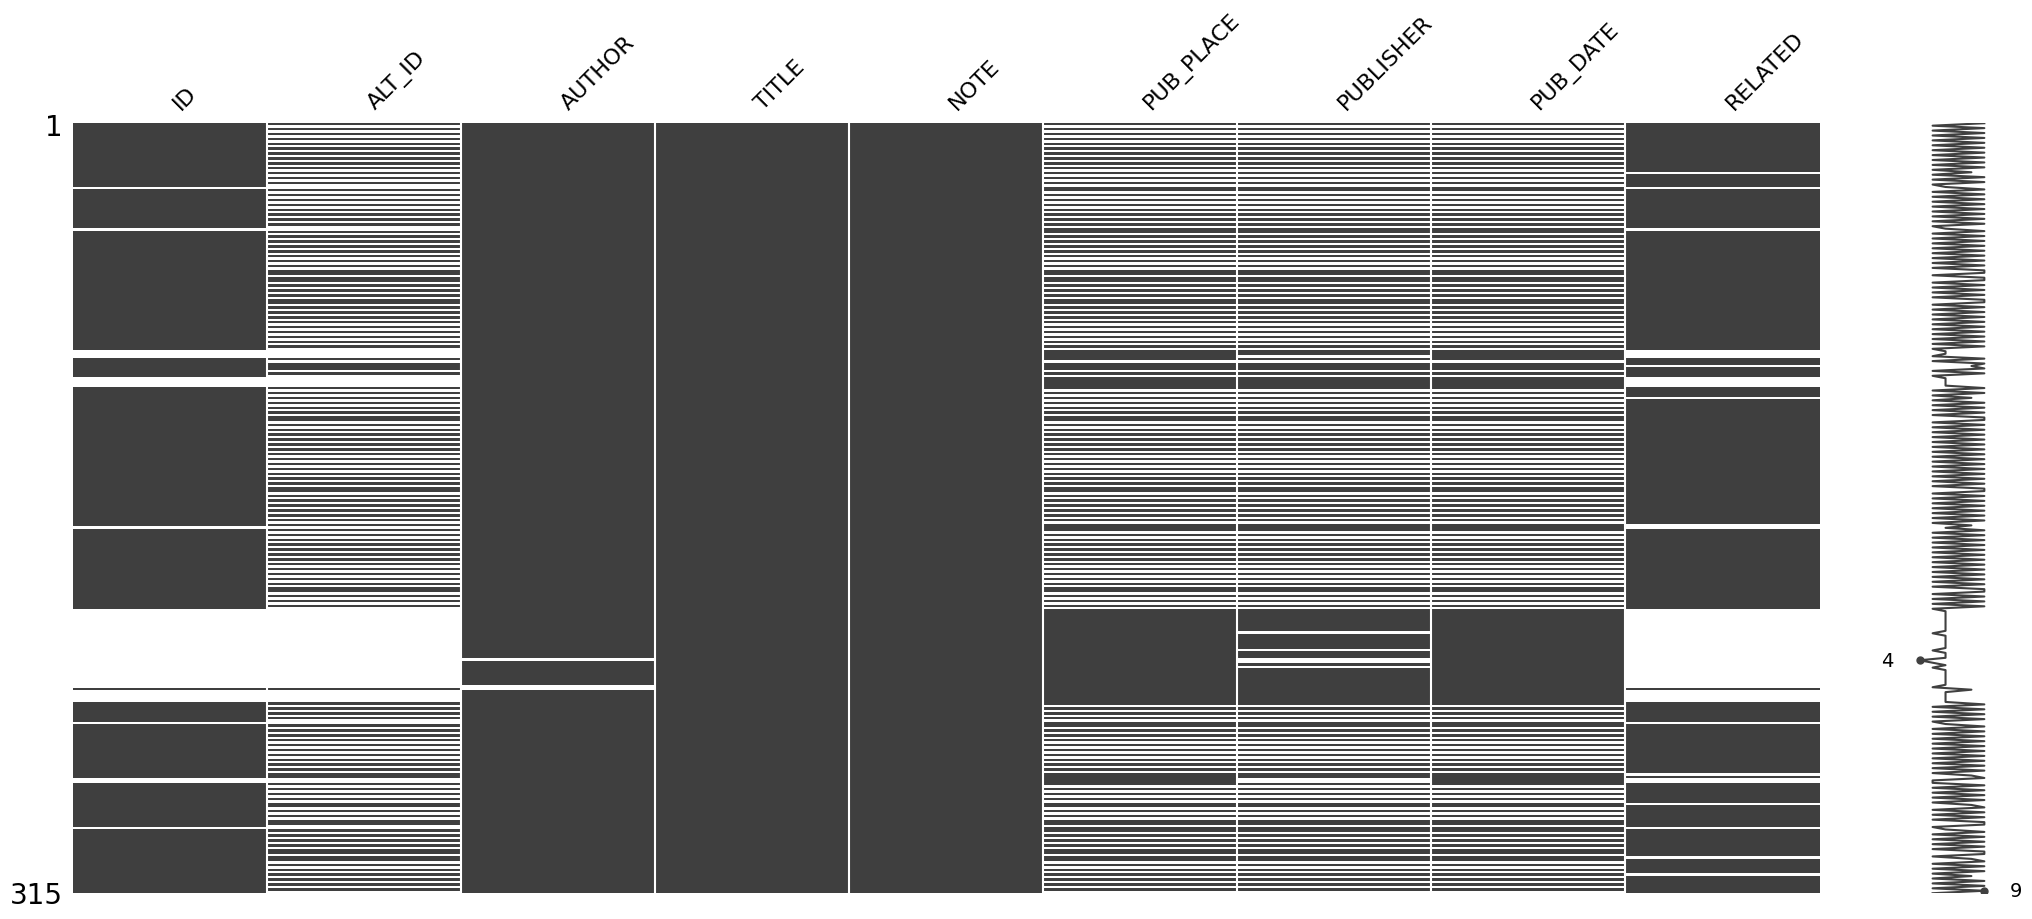

In [28]:
msgno.matrix(df)

There is a gap (nothing dramatic, but still), especially in those columns populated with identifiers

This can be a problem, since identifiers are the main reference mechanism we will use to generate a URI for each record

Let us see in detail those records that are missing their identifiers, among other information

In [31]:
df[df['ID'].isna()]

,ID,ALT_ID,AUTHOR,TITLE,NOTE,PUB_PLACE,PUBLISHER,PUB_DATE,RELATED
26,None,None,"Berkenhout, John",Clavis Anglíca linguæ botanicæ,,London,"Becket, de Houdt, Hawes, Clark & and Collins",1764,None
43,None,None,"Cleland, John","Evolution, expression, and sensation, cell lif...",Publisher's advertisements: 16 p. at end,Glasgow,James Maclehose,1881,None
93,None,None,"Murphy, Joseph John",Habit and intelligence in their connexion with...,Published in two volumes,London,Macmillan,1869,None
94,None,None,"Murphy, Joseph John",Habit and intelligence in their connexion with...,Published in two volumes,London,Macmillan,1869,None
95,None,None,"Henle, Jacob",Handbuch der systematischen Anatomie des Menschen,,Braunschweig,None,1855-71,None
104,None,None,"Vaucher, Jean Pierre Etienne","Histoire physiologique des Plantes d'Europe, o...",,Paris,Aurel Freres,1841,None
105,None,None,"Vaucher, Jean Pierre Etienne","Histoire physiologique des Plantes d'Europe, o...",,Paris,Aurel Freres,1841,None
106,None,None,"Vaucher, Jean Pierre Etienne","Histoire physiologique des Plantes d'Europe, o...",,Paris,Aurel Freres,1841,None
107,None,None,"Vaucher, Jean Pierre Etienne","Histoire physiologique des Plantes d'Europe, o...",,Paris,Aurel Freres,1841,None
165,None,None,"Reade, Winwood",The martyrdom of man /,,London,Trübner,1872,None


Now, we can deal with these missing data in various ways

on one hand, identifiers in the `ID` column are quite necessary

on the other hand, `ALT_ID` are nice to have but not necessary

`RELATED` values are very important to connect our data in a graph structure, but it is difficult (if not impossible) to automatically determine whether a record is effectively related to another or not. 

Moreover, we can notice that some of these records with missing identifiers are also repeated, so we also have to take into consideration the possibility of deleting doubles

Now, we can notice that a `ID` value is structured as follows:
> [author's surname][(publication) date][letter][letter][digit][digit][letter][_MS (if Darwin's manuscript)]



In [32]:
df.to_csv('2024-01-16_darwinslibrary.csv', index=False)

With all this in mind, we can proceed with data cleaning. but how

given our need to both clean and reconcile our data, taking a small step back from python for a moment might be a good idea

we can use openrefine